<table>
<tr>
    <td>
        <img src="https://www.wordstream.com/wp-content/uploads/2021/07/how-to-get-amazon-reviews.png" width="200"/>
    </td>
    <td style="text-align: left; vertical-align: top;">
        <h1><strong>Amazon Reviews</strong><br></h1>
        <h4>Engineering Large Scale Data Analytics Systems<br>
        ENSF 612 - Fall 2023</h4>
    </td>
</tr>
</table>


Author: Israel Suarez Robles

Completion Date: December 16, 2023, Modified on: August 22, 2024

Description: This project aims to develop a scalable multi-class sentiment analysis pipeline for Amazon reviews. It leverages Apache Spark, including Spark NLP and SparkTorch frameworks, to enable efficient data processing and inference in a distributed setup. The solution is designed to handle large-scale datasets, providing robust and accurate sentiment classification across multiple categories.

#Setting up Apache Spark, Spark NLP and GPU

In [ ]:
# Veryfing if Java is already available and the current version
# NOTE: Java 11 is pre-installed by default in google colab and compatible with our version of Spark NLP. 
# However Java might not be pre-installed in other environments.

# Verify Java installation
import subprocess, os
result = subprocess.run(['which', 'java'], stdout=subprocess.PIPE, stderr=subprocess.PIPE)

if result.returncode != 0:
    # Update package lists
    !apt-get -q update

    # Install OpenJDK 11
    !apt-get -y -q install openjdk-11-jdk

    # Set JAVA_HOME environment variable 
    os.environ['JAVA_HOME'] = '/usr/lib/jvm/java-11-openjdk-amd64'

# Verify Java version
!java -version

openjdk version "11.0.23" 2024-04-16
OpenJDK Runtime Environment (build 11.0.23+9-post-Debian-1deb10u1)
OpenJDK 64-Bit Server VM (build 11.0.23+9-post-Debian-1deb10u1, mixed mode, sharing)


In [ ]:
!pip -q install pyspark==3.3.3
!pip -q install spark-nlp==5.2.0

import sparknlp
spark = sparknlp.start(gpu = True) # for GPU training >> sparknlp.start(gpu = True)
spark.sparkContext.setLogLevel("ERROR")

sc = spark.sparkContext


[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip
:: loading settings :: url = jar:file:/root/venv/lib/python3.9/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml
Ivy Default Cache set to: /root/.ivy2/cache
The jars for the packages stored in: /root/.ivy2/jars
com.johnsnowlabs.nlp#spark-nlp-gpu_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-66e5b88a-d6f6-41f5-881f-7a286d4de59e;1.0
	confs: [default]
	found com.johnsnowlabs.nlp#spark-nlp-gpu_2.12;5.2.0 in central
	found com.typesafe#config;1.4.2 in central
	found org.rocksdb#rocksdbjni;6.29.5 in central
	found com.amazonaws#aws-java-sdk-bundle;1.11.828 in central
	found com.github.universal-automata#liblevenshtein;3.0.0 in central
	found com.google.protobuf#protobuf-java-util;3.0.0-beta-

#Loading and Joining Datasets

In [ ]:
# Clones the github repository containing the datasets
!git clone https://github.com/MENG2023-TP/ENSF612-Project.git

In [ ]:
# Shows the distinc datasets used in the project
!ls ENSF612-Project/datasets

All_Beauty.json  Cellphones_and_Accessories.json  Software.json
Appliances.json  Musical_Instruments.json	  Video_Games.json


In [ ]:
dataset_directory = 'ENSF612-Project/datasets'

# Gets the list of files in the dataset directory that end in ".json"
json_files = [file for file in os.listdir(dataset_directory) if file.endswith('.json')]

# Creates a list of full file paths
file_paths = [os.path.join(dataset_directory, file) for file in json_files]

In [ ]:
import json

# Function to parse NDJSON (new line-delimited JSON) objects and extract specific fields
def parse_ndjson(line):
    try:
        # Parse the JSON line and return only reviewText asin and reviewerID
        json_line = json.loads(line)
        return (
            json_line.get('overall', ''),
            json_line.get('reviewText', '')
        )
    except json.JSONDecodeError:
        # In case of error, skip this record and return None
        return None

In [ ]:
# Initialize an empty RDD
data_rdd = spark.sparkContext.emptyRDD()

# Read each file into an RDD and parse its ndjson objects if not None
# Note: a new file_rdd and data_rdd is created for each iteration
for file_path in file_paths:
    file_rdd = sc.textFile(file_path, 4)
    parsed_rdd = file_rdd.map(parse_ndjson).filter(lambda x: x is not None)
    data_rdd = data_rdd.union(parsed_rdd)

# Convert the final data_rdd to a distributed Spark DataFrame
df = spark.createDataFrame(data_rdd, schema=['score', 'review']).cache()

#Data Inspection and Validation

In [ ]:
# Shows type of df
type(df)

pyspark.sql.dataframe.DataFrame

In [ ]:
# Shows attributes of df
df

DataFrame[score: double, review: string]

In [ ]:
# Previews the contect of a single record
df.take(1)

[Row(score=5.0, review='As advertised. Reasonably priced')]

In [ ]:
# Counts amount of records in the DataFrame
df.count()

24380

In [ ]:
# Counts and shows amount of null values
from pyspark.sql.functions import col, sum

df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns]).cache().show()

+-----+------+
|score|review|
+-----+------+
|    0|     0|
+-----+------+



In [ ]:
# Distribution of records by score in the DataFrame

from pyspark.sql import functions as F

# Count the number of reviews for each star rating
star_rating_counts = df.groupBy("score").count()

# Rename the columns
star_rating_counts = star_rating_counts.withColumnRenamed("score", "Star Rating").withColumnRenamed("count", "Count").show()

+-----------+-----+
|Star Rating|Count|
+-----------+-----+
|        1.0| 1122|
|        4.0| 3600|
|        3.0| 2064|
|        2.0|  884|
|        5.0|16710|
+-----------+-----+



In [ ]:
# Create a new balanced DataFrame by undersampling over-represented classes

from pyspark.sql.functions import col, sum

# Assuming you have a DataFrame df with a "score" column
star_rating_counts = df.groupBy("score").agg(F.count("score").alias("Count"))

# Find the smallest class size
smallest_class_size = star_rating_counts.selectExpr("min(Count)").first()[0]

# Sample each class based on the smallest class size
df_balanced = df.filter(col("score") == 1.0).sample(False, smallest_class_size / star_rating_counts.filter(col("score") == 1.0).first()[1])
df_balanced = df_balanced.unionAll(df.filter(col("score") == 2.0))
df_balanced = df_balanced.unionAll(df.filter(col("score") == 3.0).sample(False, smallest_class_size / star_rating_counts.filter(col("score") == 3.0).first()[1]))
df_balanced = df_balanced.unionAll(df.filter(col("score") == 4.0).sample(False, smallest_class_size / star_rating_counts.filter(col("score") == 4.0).first()[1]))
df_balanced = df_balanced.unionAll(df.filter(col("score") == 5.0).sample(False, smallest_class_size / star_rating_counts.filter(col("score") == 5.0).first()[1]))


In [ ]:
# Count the number of reviews for each star rating
star_rating_counts = df_balanced.groupBy("score").count()

# Rename the columns
star_rating_counts = star_rating_counts.withColumnRenamed("score", "Star Rating").withColumnRenamed("count", "Count").show()

+-----------+-----+
|Star Rating|Count|
+-----------+-----+
|        1.0|  883|
|        2.0|  884|
|        3.0|  901|
|        4.0|  870|
|        5.0|  882|
+-----------+-----+



#Method 1: Training a Deep Learning Classifier using BERT Sentence Embeddings in Spark NLP

##Splitting the dataset into training and validation sets

In [ ]:
from sparknlp.base import *
from sparknlp.annotator import *
from sparknlp.training import *

# Define the sample size for the validation set
validation_sample_size = 0.25

# Split the DataFrame into training and validation sets
train_df, val_df = df_balanced.randomSplit([1 - validation_sample_size, validation_sample_size], seed=42)

##OPTION 1: Training and saving a new model (Skip when importing)

Defining pipeline

In [ ]:
# DocumentAssambler: this stage is a Spark NLP tranformer used to convert the raw text data
# into a format that can be used for text proccesing.
document = DocumentAssembler()\
    .setInputCol("review")\
    .setOutputCol("document")

# BertSentenceEmbeddings: This stage utilizes a pre-trained sentence BERT model to convert the document
# into sentence embeddings. Sentence embeddings are designed to represent the entire sentence as a
# single fixed-size vector. This vector aims to capture the overall meaning and context of the sentence.
bert_sent = BertSentenceEmbeddings.pretrained('sent_bert_base_uncased')\
    .setInputCols(["document"])\
    .setOutputCol("sentence_embeddings")

# ClassifierDLApproach: this stage uses a Deep Learning classifier that takes the sentence embeddings as
# input and performs classification.
classsifierdl = ClassifierDLApproach()\
    .setInputCols(["sentence_embeddings"])\
    .setOutputCol("class") \
    .setLabelColumn("score") \
    .setMaxEpochs(10)\
    .setEnableOutputLogs(True)\
    .setLr(0.001)

bert_sent_clf_pipeline = Pipeline(stages = [document, bert_sent, classsifierdl])

sent_bert_base_uncased download started this may take some time.
Approximate size to download 392.5 MB
[OK!]


In [ ]:
# Train model
%%time
bert_sent_pipelineModel = bert_sent_clf_pipeline.fit(train_df)

In [ ]:
# Printing training logs

log_files = os.listdir("/root/annotator_logs")

with open("/root/annotator_logs/"+log_files[0], "r") as log_file :
    print(log_file.read())

Saves, zips and downloads the model

In [ ]:
from google.colab import files

bert_sent_pipelineModel.save("bert_sent_clf") # This saves the model
!zip -r bert_sent_clf.zip bert_sent_clf  # This zips the directory
files.download('bert_sent_clf.zip')  # This downloads the zip file

##OPTION 2: Importing pre-trained model.

In [ ]:
%%capture
!unzip bert_sent_clf.zip # Unzip file containing config, model and training_args files

In [ ]:
bert_sent_pipelineModel = PipelineModel.load("bert_sent_clf") # Load pre-trained pipeline model

##Evaluating model performance

In [ ]:
from sklearn.metrics import classification_report

preds = bert_sent_pipelineModel.transform(val_df)

preds_df = preds.select('score','review',"class.result").toPandas()

preds_df['result'] = preds_df['result'].apply(lambda x : x[0])

In [ ]:
# Convert the 'result' column to numeric
preds_df['result'] = preds_df['result'].astype(float)

# Print the classification report
print(classification_report(preds_df['score'], preds_df['result']))

              precision    recall  f1-score   support

         1.0       0.57      0.80      0.67       212
         2.0       0.39      0.44      0.41       214
         3.0       0.69      0.21      0.32       236
         4.0       0.37      0.47      0.41       209
         5.0       0.67      0.64      0.65       227

    accuracy                           0.51      1098
   macro avg       0.54      0.51      0.49      1098
weighted avg       0.54      0.51      0.49      1098



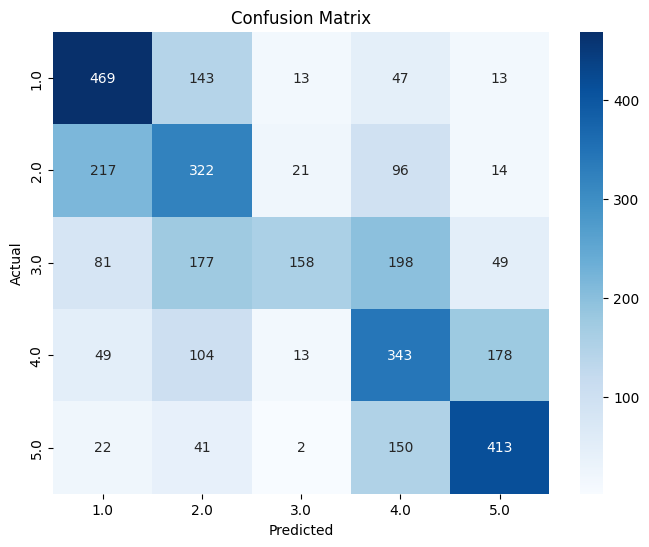

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the confusion matrix
conf_matrix = confusion_matrix(preds_df['score'], preds_df['result'])

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['1.0', '2.0', '3.0', '4.0', '5.0'], yticklabels=['1.0', '2.0', '3.0', '4.0', '5.0'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

**Method 1 summary:** this method implements a custom made pipeline to train a  deep learning classifier model  to classify text based on features extracted by the BERT sentence embeddings. The chosen pretrained model used to generate the embeddigs is sent_bert_base_uncased. The entire process is performed by using Spark NLP and leverage its distributed capabilities.

Since the ClassifierDLApproach model is sensitive to imbalanced data, we trained the model using a balanced DataFrame obtained by applying undersampling. Note that undersampling did not affect negatively the accuracy of the model when compared to over sampling. Thus for efficiency the undersampling approach was maintained.

The model obtained with this strategy yield an accuracy score of 0.51. Thus the model did not perform well enough for our fine graded sentiment analysis application which requires subdividing sentiment indicators into distinct categories (1 star to 5 stars).

However upon analysing the confusion matrix we can note that the mayority of the missclassfications occur in close proximity to their true labels (2 instead of 1, 1 instead of 2, 2 and 4 instead of 3, 5 instead of 4 and 4 instead of 5). Because of the close proximity of the missclassifications we can conclude that this model would have yield a much higher accuracy for simpler sentiment analysis applications that only classify sentiment with negative, neutral and positive labels.


#Method 2: Fine-Tuning BertForSequenceClassification model from Hugging Face Transformers library

In [ ]:
import torch
torch.__version__

'1.12.1+cu102'

In [ ]:
# Importing required modules

# PyTorch
from torch.utils.data import Dataset, DataLoader, random_split
if torch.cuda.is_available():
  print(torch.cuda.current_device())
  print(torch.cuda.get_device_name(0))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hugging Face Transformers
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments

# Accelerate
import accelerate
print(f"Accelerate version: {accelerate.__version__}")

2024-08-24 21:12:59.369596: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-24 21:12:59.585765: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-08-24 21:12:59.585795: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-08-24 21:12:59.631235: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-24 21:13:00.483392: W tensorflow/stream_executor/pla

##Text Pre-Processing

In [ ]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType, ArrayType, IntegerType

"""
Expanding contractions

Note:
Expanding contractions is an optional preprocessing step that can improve text
clarity and consistency. It can benefit models that rely on tokenization by ensuring
uniformity in text representation, which may enhance feature extraction and overall
model performance. This step is particularly useful for formal text or models
sensitive to explicit language patterns.
"""

import contractions

# Define the UDF for expanding contractions
def expand_contractions_text(text):
  return contractions.fix(text)

expand_contractions_udf = udf(expand_contractions_text, StringType())

# Apply the UDF to the DataFrame to create a new column with expanded contractions
expanded_df = df.withColumn("expanded_review", expand_contractions_udf("review"))

"""
BERT Tokenization
"""

# Initialize BERT Tokenizer
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Function to tokenize and handle max length
def bert_tokenize(text):
  return bert_tokenizer.encode(text, add_special_tokens=True, max_length=512, truncation=True, padding='max_length')

bert_tokenize_udf = udf(bert_tokenize, ArrayType(IntegerType()))

# Apply the BERT Tokenizer UDF
bert_df = expanded_df.withColumn("bert_tokens", bert_tokenize_udf("expanded_review"))

# Show the processed data
bert_df.show(5)

/root/venv/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
+-----+--------------------+--------------------+--------------------+
|score|              review|     expanded_review|         bert_tokens|
+-----+--------------------+--------------------+--------------------+
|  5.0|As advertised. Re...|As advertised. Re...|[101, 2004, 17099...|
|  5.0|Like the oder and...|Like the oder and...|[101, 2066, 1996,...|
|  1.0|I bought this to ...|I bought this to ...|[101, 1045, 4149,...|
|  5.0|HEY!! I am an Aqu...|HEY!! I am an Aqu...|[101, 4931, 999, ...|
|  5.0|If you ever want ...|If you ever want ...|[101, 2065, 2017,...|
+-----+--------------------+---------------

In [ ]:
print(type(bert_df))


<class 'pyspark.sql.dataframe.DataFrame'>


In [ ]:
# Save as Parquet
bert_df.write.parquet('path_to_directory/bert_df.parquet', mode='overwrite')


In [ ]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

# Function to convert array to comma-separated string
def array_to_string(arr):
    if arr is not None:
        return ','.join(map(str, arr))
    return None

# Register the UDF
array_to_string_udf = udf(array_to_string, StringType())

# Apply the UDF to convert array columns
for column in bert_df.columns:
    if isinstance(bert_df.schema[column].dataType, ArrayType):
        bert_df = bert_df.withColumn(column, array_to_string_udf(bert_df[column]))

# Save Spark DataFrame to CSV
bert_df.write.csv('path_to_directory/bert_df.csv', header=True, mode='overwrite')


In [ ]:
"""
Converting Spark DataFrame for Training BertForSequenceClassification with PyTorch.

Note:
Although SparkNLP and SparkTorch frameworks allow using pretrained transformer models
for inference they do not offer native support for distributed training.

For that reason, this script converts the Spark DataFrame to a Pandas DataFrame
and then into PyTorch tensors using a custom dataset loader.

"""

# Convert Spark DataFrame to Pandas DataFrame
pandas_df = bert_df.select("score", "bert_tokens").toPandas()

# Adjust labels from 1-5 to 0-4 and convert to integers
pandas_df['score'] = pandas_df['score'] - 1
pandas_df['score'] = pandas_df['score'].astype(int)
unique_labels = pandas_df['score'].nunique()

# Define a custom Dataset class for PyTorch

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

class BertDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Convert the Pandas DataFrame to a PyTorch Dataset
encodings = {'input_ids': list(pandas_df['bert_tokens']), 'attention_mask': [[int(token_id > 0) for token_id in tokens] for tokens in pandas_df['bert_tokens']]}
labels = pandas_df['score'].tolist()
dataset = BertDataset(encodings, labels)

##Splitting the dataset into training, validation and testing sets

In [ ]:
total_size = len(dataset)
train_size = int(0.8 * len(dataset))            # 80%
val_size = int(0.1 * len(dataset))              # 10%
test_size = total_size - train_size - val_size  # 10%, ensuring no rounding issues

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

###OPTION 1: Fine-tuning BertForSequenceClassification model (Skip when importing)

In [ ]:
# Define the BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=unique_labels)
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
 # Setting up the training parameters and the training loop using Hugging Face's trainer

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',          # Checkpoints output
    num_train_epochs=3,              # Number of training epochs
    per_device_train_batch_size=8,   # Batch size for training
    per_device_eval_batch_size=8,    # Batch size for evaluation
    warmup_steps=500,                # Number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # Weight decay if we apply some.
    logging_dir='./logs',            # Directory for storing logs
    logging_steps=10,
)

# Create a Trainer instance
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)

# val_dataset is only used to evaluate and monitor model performance during training.
# The current setup does not implement hyper parameter tuning or early stopping.

In [ ]:
# Train the model
trainer.train()

KernelInterrupted: Execution interrupted by the Jupyter kernel.

In [ ]:
# Alternatively resume training
trainer.train(resume_from_checkpoint="./results/checkpoint-7314")

Saves, zips and downloads the model

In [ ]:
trainer.save_model("bert_sequence")  # Save model
!zip -r bert_sequence.zip bert_sequence  # Zip directory
files.download('bert_sequence.zip')  # Download file

###OPTION 2: Import fined tunned BertForSequenceClassification model and re-create trainer instance.

In [ ]:
!unzip bert_sequence.zip # Unzip file containing config, model and training_args files

unzip:  cannot find or open bert_sequence.zip, bert_sequence.zip.zip or bert_sequence.zip.ZIP.


In [ ]:
model = BertForSequenceClassification.from_pretrained("bert_sequence") # Import pretrained model
training_args = torch.load('bert_sequence/training_args.bin') # Import training arguments

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset
)

##Evaluating model performance

In [ ]:
results = trainer.evaluate(eval_dataset=test_dataset) # Evaluation using test_dataset
print(results)

NameError: name 'evaluation_results' is not defined

In [ ]:
predictions = trainer.predict(test_dataset)

In [ ]:
predicted_labels = predictions.predictions.argmax(-1)

In [ ]:
print(predicted_labels)

In [ ]:
true_labels = [item['labels'] for item in test_dataset]


In [ ]:
from sklearn.metrics import precision_score, recall_score

precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
accuracy = (predicted_labels == true_labels).mean()

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'Accuracy: {accuracy}')

**Method 2 summary:** this method implements 3 pre-proccesing steps: expanding contractions, tokenization using Bert, and converting the Spark DataFrame into a custom BertDataset compatible with PyTorch. After transforming tha data, we fit the training dataset into a BertForSequenceClassification which allows us to fine-tune the general-purpose bert-base-uncased model and add a classification layer on top tailored for our specific fine-grained sentiment analysis application.

This sequence-based approach is particularly effective for fine-grained sentiment analysis because it is designed to understand the entire sequence of the words in the context. Unlike the ClassifierDL model that uses precomputed embeddings, it can dynamically interpret the text and detect subtle shifts in tone and meaning that are essential for distinguishing between closely ranked sentiment categories (like a 4-star vs. 5-star rating).

Transforming the Spark DataFrame into a custom python dataset compatible with PyTorch is a common hybrid approach use in large data analysis. Which consist of implementing Spark NLP for pre-proccesing of large amounts of data in a distributed enviroment, while PyTorch is utilized for advanced model training and fine-tuning capabilities. Sampling or downsizing is often required to accommodate the memory constraints of single-machine training. This strategy is particularly advantageous and often used because although the Spark NLP library supports the import of pre-trained models like BertForSequenceClassification it lacks the capability for fine-tuning these models, a task typically and effectively handled by PyTorch or TensorFlow.

The model obtained with this method yield a precision, recall and accuracy score of 0.91. Indicating that this model is well suited for our multi-graded sentiment analysis approach and capable of performing sentiment analysis into 5 distinct categories (1 star to 5 stars).


#Performing distributed sentiment analysis inference with SparkTorch using fine-tunned BertForSequenceClassification model

In [ ]:
new_reviews = [
    "This is the best album I have ever listened to in my entire life.",
    "Do not buy this microwave.",
    "I absolutely love this costume! It has exceeded all my expectations.",
    "The tooth brush is average",
    "Does the job but nothing exceptional.",
    "Really disappointed with these new air pods. It didn't live up to the hype."
]

# Tokenize the new reviews
tokenized_reviews = [bert_tokenize(review) for review in new_reviews]

# Prepare the encodings for the dataset
encodings = {
    'input_ids': [bert_tokenizer.encode(review, add_special_tokens=True, max_length=512, truncation=True, padding='max_length') for review in new_reviews],
    'attention_mask': [[int(token_id > 0) for token_id in tokens] for tokens in tokenized_reviews]
}

# Create the dataset using your BertDataset class, generate dummy labels since they are not used in prediction
small_dataset = BertDataset(encodings, [0 for _ in new_reviews])

# Predict using the Trainer instance
predictions = trainer.predict(small_dataset)
predicted_labels = predictions.predictions.argmax(-1) + 1

# Print the predictions
print(predicted_labels)


[5 1 5 4 3 2]


# Conclusion

 The two methods for sentiment analysis offer contrasting insights.

Method 1, utilizing Spark NLP ClassifierDLApproach with precomputed BERT sentence embeddings, is efficient for distributed processing. It's model is well suited for traditional sentiment analysis involving negative, neutral, and positive labels but is less effective for nuanced sentiment analysis due to its moderate performance and tendency for near-miss classifications.

Method 2, with BertForSequenceClassification in PyTorch, is superior for fine-grained sentiment analysis due to its sequence-based modeling capable of capturing the context and subtle sentiment shifts.

This contrast highlights the importance of choosing the right model based on the specific requirements of the sentiment analysis task in a Spark distributed computing enviroment.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=8067bc08-70d1-42ef-8971-b9437e40bd21' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>